# Assignment 1:

* Hany Hamed
* Introduction to Computer Vision - Innopolis University - Fall 2021


In this assignmet, it is required to complete 3 main tasks using classical computer vision algorithms using OpenCV

# Installing libraries, helper functions & downloading required images


In [9]:
# Import libraries
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
import cv2
import numpy as np
from copy import deepcopy
import scipy.stats as st


# Set inline plots size
plt.rcParams["figure.figsize"] = (20, 20) # (w, h)


In [2]:
# Download images
!wget "https://drive.google.com/uc?export=view&id=1Iq2Wm57vwm4wsT3n3QvsGU4cZYgo6ARa" -O task1.png
!wget "https://drive.google.com/uc?export=view&id=1ho2Wf2RHmeSktY0UD2zf9-kclpnAognG" -O task2.png
!wget "https://drive.google.com/uc?export=view&id=1FdJqD04_l8n3sFl3QotxOcyH07ndEVm6" -O task3.png
clear_output()

In [3]:
# Source: lab3
def read_and_resize(filename, grayscale=False, fx=0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result

# Source: lab3
def showInRow(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

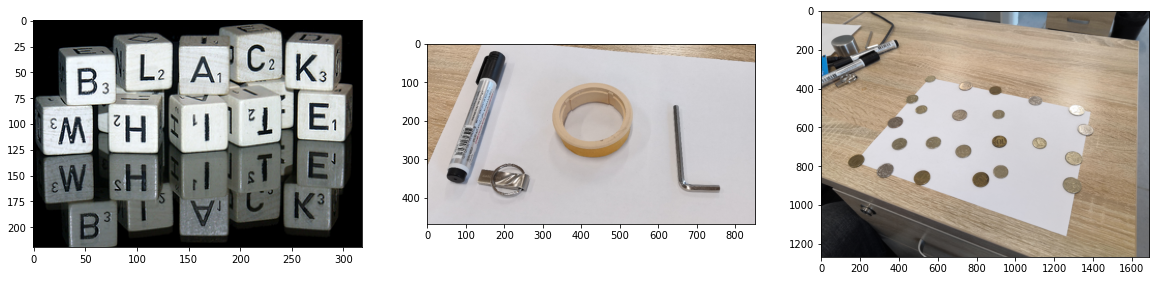

In [12]:
task1, task2, task3 = read_and_resize('task1.png', fx=1, fy=1), read_and_resize('task2.png', fx=0.25, fy=0.25), read_and_resize('task3.png', fx=0.3, fy=0.3)
showInRow([task1, task2, task3])

# Task1: Adaptive Threshold implementation

Adaptive threshold algorithm is an algorithm that calculates a threshold value for each cell in the input image instead of a global threshold value accross the whole image. Thus, it provides a robust threshold algorithm for difficult images in terms of different brightnesses in different parts in the image.

The algorithm works as following:

1. Move a 2D kernel accross the image, this kernel represents the neighbourhood of the cell
2. Calculate the mean of the neighbourhood
3. Calculate the value of the threshold: $T = mean(I_k) - C$

Such as, $I_k$ is the intensity of the neighbourhood for each cell (The cells that masked with kernel), and C is a value that can be tuned.


Regarding the mean, the algorithm has two variants in calculating the mean to get the threshold value:

* Mean: here we calculate the arithmetic mean for the neighbourhood for a specific cell

* Gaussian: here we calculate a weighted value of the neighbours using a 2D gaussian kernal and calculate the mean of that resulted neighbours.

In [5]:
def adaptive_thresholding(img, thresholding_type="mean", block_size=3, C=2):
  """
  Function calculates adaptive thresholding for a given image
  Input:
    image: grayscale or color image (BGR)
    thresholding_type : type of thresholding ;
                        possible values : ’mean ’ and ’gaussian ’
    block_size : kernel size in which the threshold value is
                  calculated for the current pixel
    Output :
      image_bw : binary thresholded image
  """

  # Based on: https://www.geeksforgeeks.org/how-to-generate-2-d-gaussian-array-using-numpy/
  def gkern(mu=0, sigma=1, kernlen=3, nsig=1):
    """
    Function to compute the 2D gaussian kernel
    Input:
    mu: mean of the guassian distribution
    sigma: sqrt(variance of the gaussian distribution)
    nsig: range of the linspace for the values of the gaussian distribution
    kernlen : kernel size
    Output :
      gauss : 2D gaussian kernel 
    """
    x, y = np.meshgrid(np.linspace(-nsig, nsig, kernlen), np.linspace(-nsig, nsig, kernlen))
    dst = np.sqrt(x*x+y*y)

    # Calculating Gaussian array
    gauss = np.exp(-( (dst-mu)**2 / ( 2.0 * sigma**2 ) ) )
    return gauss #/gauss.sum()

  img_gray = deepcopy(img)  # Copy the real image
  # Check if it is colored or not
  if (len(img.shape) > 2 and img.shape[2] > 1): # if it is colored
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert it to grayscale

  padding = block_size // 2 # Padding size in order to pad the image from top, bottom, right, left
  img_gray_padded = np.zeros(shape=(img_gray.shape[0]+2*padding, img_gray.shape[1]+2*padding))  # Empty array with the same dimensions of the padded image
  img_gray_padded[padding:padding+img_gray.shape[0], padding:padding+img_gray.shape[1]] = img_gray[:,:] # Fill the padded image with the image in the center
  # showInRow([img_gray, img_gray_padded])

  img_bw = np.zeros(shape=img_gray_padded.shape, dtype=np.int16)  # Empty image to store black and white result image

  # Two loops to pass accross the whole image
  for r in range(padding, padding+img_gray.shape[0]):
    for c in range(padding, padding+img_gray.shape[1]):
      block = deepcopy(img_gray_padded[r-padding:r+padding+1, c-padding:c+padding+1]) # Block that contins the neighbourhood

      if (thresholding_type == "mean"):
        block = block
        # mean = np.mean(block)

      elif (thresholding_type == "gaussian"): # if it is gaussian way to compute the mean
        # cross-correlation of the block with a Gaussian window
        gaussian_window = gkern(kernlen=block_size, nsig=1/block_size)  # Create gaussian kernel
        block = block * gaussian_window # Element-wise multiplication

      else:
        raise ValueError("Not correct type for threshold")
      mean = np.mean(block) # Compute the mean
      thresh_val = mean - C # Calculate the threshold
      img_bw[r, c] = 255 if img_gray_padded[r, c] > thresh_val else 0 # Compute the pixel result based on the threshold

  return img_bw[padding:padding+img_gray.shape[0], padding:padding+img_gray.shape[1]] # Return the image with the original dimensions


## Compare between cv2 and my implementation


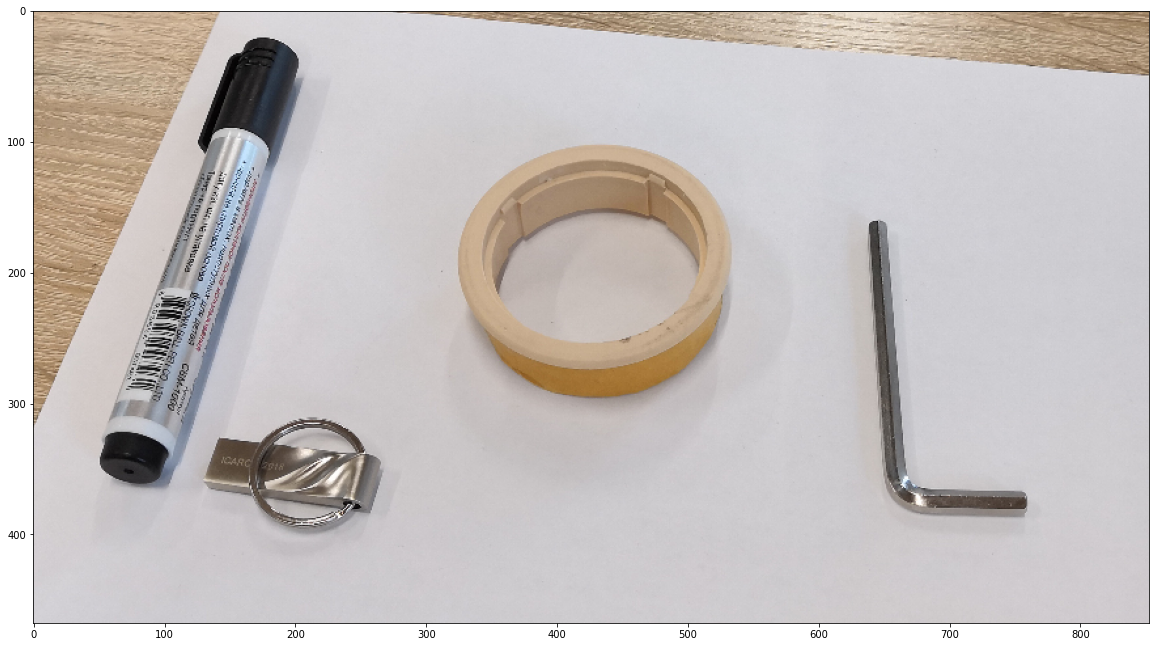

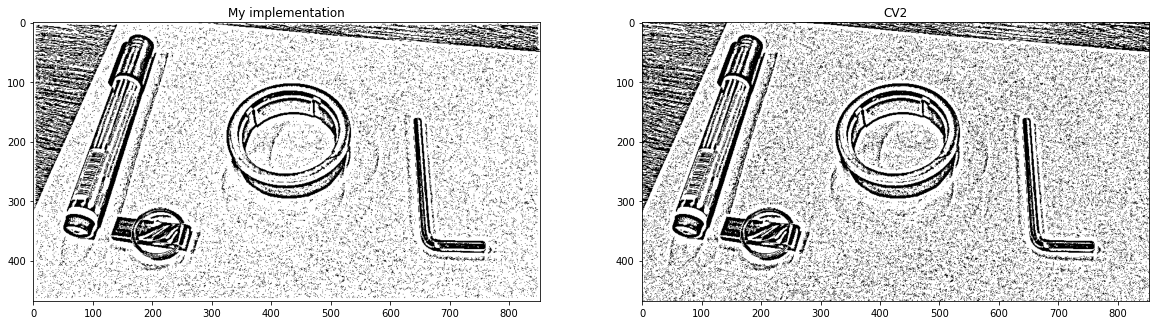

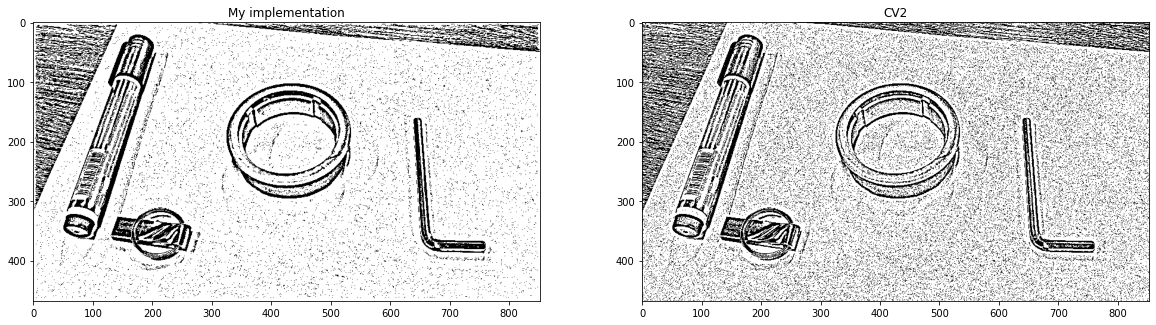

In [13]:
# TODO: add slider to change the block size
img = task2
showInRow([img])

img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grey

img_bw1 = adaptive_thresholding(img, thresholding_type="mean", block_size=11) # compute the threshold image using my implementation
th1 = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
showInRow([img_bw1, th1], titles=["My implementation", "CV2"])  

img_bw2 = adaptive_thresholding(img, thresholding_type="gaussian", block_size=11)
th2 = cv2.adaptiveThreshold(img_grey,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
showInRow([img_bw2, th2], titles=["My implementation", "CV2"])

# Task2: Calculate dimensions

Here, we are asked to detect, calculate and rank the objects in the image.

The code is as following:

1. Convert to greyscale
2. Blur the image using gaussian blur
3. Apply threshold
4. Apply erosion to remove some white noise
5. Find contours
6. Sort them based on the rank criteria
7. Calculate the metric and draw them on image


I have tuned the valuse for the threshold and the values for the erosion

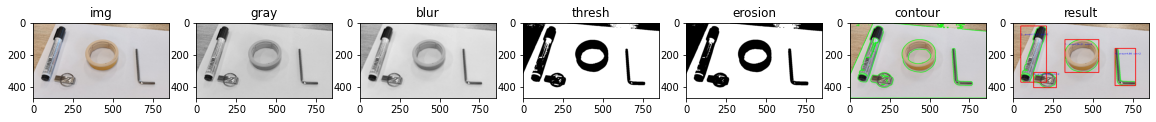

heights: [205, 351, 95, 232]
widths: [211, 160, 142, 128]
perimeters: [696.4406894445419, 1041.5777699947357, 401.8477602005005, 685.3797237873077]
areas: [34473.0, 21656.0, 9172.0, 6922.5]


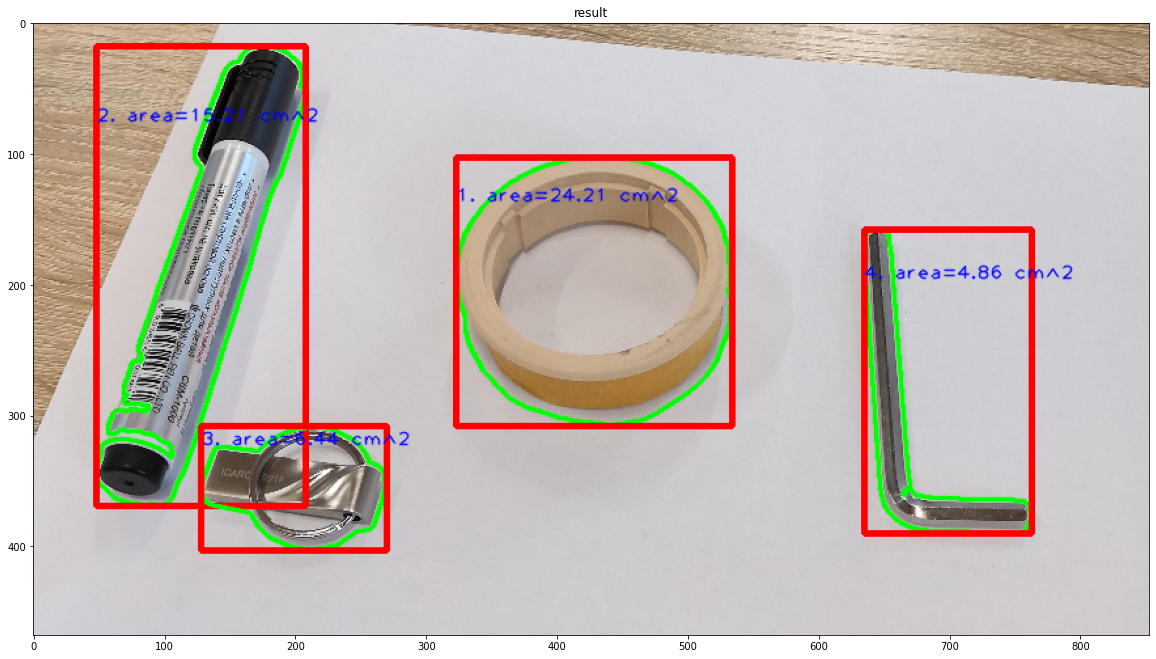

In [10]:
def calculate_sizes_and_rank(img, units="pixels", rank_by="area", max_num_objects=5):
  """
  Function calculates objects sizes and rank them on image
  Input:
    image : grayscale or color image
    units : unit of measurement of object size;
            possible values : ’mm ’,’cm ’, ’m’ or ’pixels’
    rank_by : object ranking parameter ; 
              possible values : ’height ’, ’width ’, ’perimeter ’ or ’area ’
  Output :
    image_result : result image with ranking and measured objects sizes
    sizes : tuple of sizes (heights , widths , perimeters , areas ), where heights , widths , perimeters , areas are lists
  """
  # Arrays to store the sizes
  heights = []
  widths = []
  perimeters = []
  areas = []

  img_result = deepcopy(img)  # image to store the result
  img_gray = deepcopy(img)    # image to be manipulated to extract the objects

  # Check if it is colored or not
  if (len(img.shape) > 2 and img.shape[2] > 1): # colored
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  img_list = [img, img_gray]  # array to store the transitions of the image
  img_list_labels = ["img", "gray"]

  # Blur the gray image
  img_blur = cv2.GaussianBlur(img_gray, (7,7), 0)
  img_list.append(img_blur)
  img_list_labels.append("blur")

  # Threshold the image
  ret, thresh = cv2.threshold(img_blur , 175, 255, cv2.THRESH_BINARY)
  img_list.append(thresh)
  img_list_labels.append("thresh")

  # Apply erosion
  erosion = cv2.erode(thresh, np.ones((3,3),np.uint8),iterations = 1)
  img_list.append(erosion)
  img_list_labels.append("erosion")

  # Find contours
  contours, hierarchy = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Draw contour on temporary image just for debugging
  contour_img = deepcopy(img)
  cv2.drawContours(image=contour_img, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
  img_list.append(contour_img)
  img_list_labels.append("contour")


  # Sort contours
  sorting_function = None
  if (rank_by == "area"):
    sorting_function = lambda c: cv2.contourArea(c)
  elif (rank_by == "width"):
    sorting_function = lambda c: cv2.boundingRect(c)[2]
  elif (rank_by == "height"):
    sorting_function = lambda c: cv2.boundingRect(c)[3]
  elif (rank_by == "perimeter"):
    sorting_function = lambda c: cv2.arcLength(c,True)
  else:
    raise ValueError("Wrong error for rank_by parameter")    

  contours_sorted = sorted(contours, key=sorting_function, reverse = True)
  
  objects_contour_list = [] # To store the contours of the objects
  for i,cnt in enumerate(contours_sorted[1:]): # Avoid the outer contour
    if(len(objects_contour_list) >= max_num_objects): # Avoid unneccessary contours as we have expected number of objects
      break
    x, y, w, h = cv2.boundingRect(cnt)

    # In order to avoid a case when a object has two contours one inside the object and oe outside object
    # e.g. when the contour of the mug holder internal is inside the mug holder's contour boarder
    # This can be resolved if the binary image is inverted and the background is black, but the current one is good and working
    contour_inside_object = False
    for c in objects_contour_list:
      if (cv2.pointPolygonTest(c, (x,y), True) > 0):  # if the top point of the bounding box is inside another box then do not consider it as an object, it might be the internal of an object
        contour_inside_object = True
        break
    if (contour_inside_object):
      continue

    cv2.drawContours(image=img_result, contours=[cnt], contourIdx=0, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)  # Draw the contour

    # Get area and perimeter
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)

    # Draw rectangle and text
    img_result = cv2.rectangle(img_result, (x,y), (x+w,y+h), (255,0,0), 3)
    # Conversion for the metric value
    postfix = ""
    cm_conversion_coeffecient = 0.0265 # approximation as it was asked from the assignment to provide just an approximation based on the known object sizes (Not caring for now about calibration, perspective)
    if (rank_by == "area"):
      dim = area#w*h
      postfix = "^2"
      cm_conversion_coeffecient *= cm_conversion_coeffecient # cm_conversion_coeffecient^2 -> approximation as it was asked from the assignment to provide just an approximation based on the known object sizes (Not caring for now about calibration, perspective)
    elif (rank_by == "width"):
      dim = w
    elif (rank_by == "height"):
      dim = h
    elif (rank_by == "perimeter"):
      dim = perimeter

    if (units == "pixels"):
      dim *= 1
    elif (units == "cm"):
      dim *= cm_conversion_coeffecient
    elif (units == "mm"):
      dim *= cm_conversion_coeffecient*10
    else:
      raise ValueError("Not correct value for units parameters")

    text = f'{len(objects_contour_list)+1}. {rank_by}={dim:.2f} {units}{postfix}'
    cv2.putText(img_result, text, (x,y+h//6), cv2.FONT_HERSHEY_PLAIN, 1, (0,0,255), 1, cv2.LINE_AA) # put text on the image

    # Append to lists
    heights.append(h)
    widths.append(w)
    perimeters.append(perimeter)
    areas.append(area)
    objects_contour_list.append(cnt)

  img_list.append(img_result)
  img_list_labels.append("result")

  showInRow(img_list, titles=img_list_labels)
  sizes = (heights, widths, perimeters, areas)
  return img_result, sizes

img = task2
img_result, sizes = calculate_sizes_and_rank(img, rank_by="area", units="cm", max_num_objects=4)
print(f"heights: {sizes[0]}")
print(f"widths: {sizes[1]}")
print(f"perimeters: {sizes[2]}")
print(f"areas: {sizes[3]}")
showInRow([img_result], titles=["result"])

# Task3: Count coins

Here, we are asked to count the number of coins that are not touching the boarder of the paper.

The code is as following:

1. Convert to greyscale
2. Blur the image using gaussian blur
3. Apply threshold
4. Apply closing to close the small holes inside the foreground objects (white objects)
5. Apply erosion to remove some white noise with certain number of iterations
6. Apply dialation to increase the white boarders with certain number of iterations
7. Find contours

I have tuned the valuse for the threshold and the values for the erosion, dilation and closing kernels and number of iterations

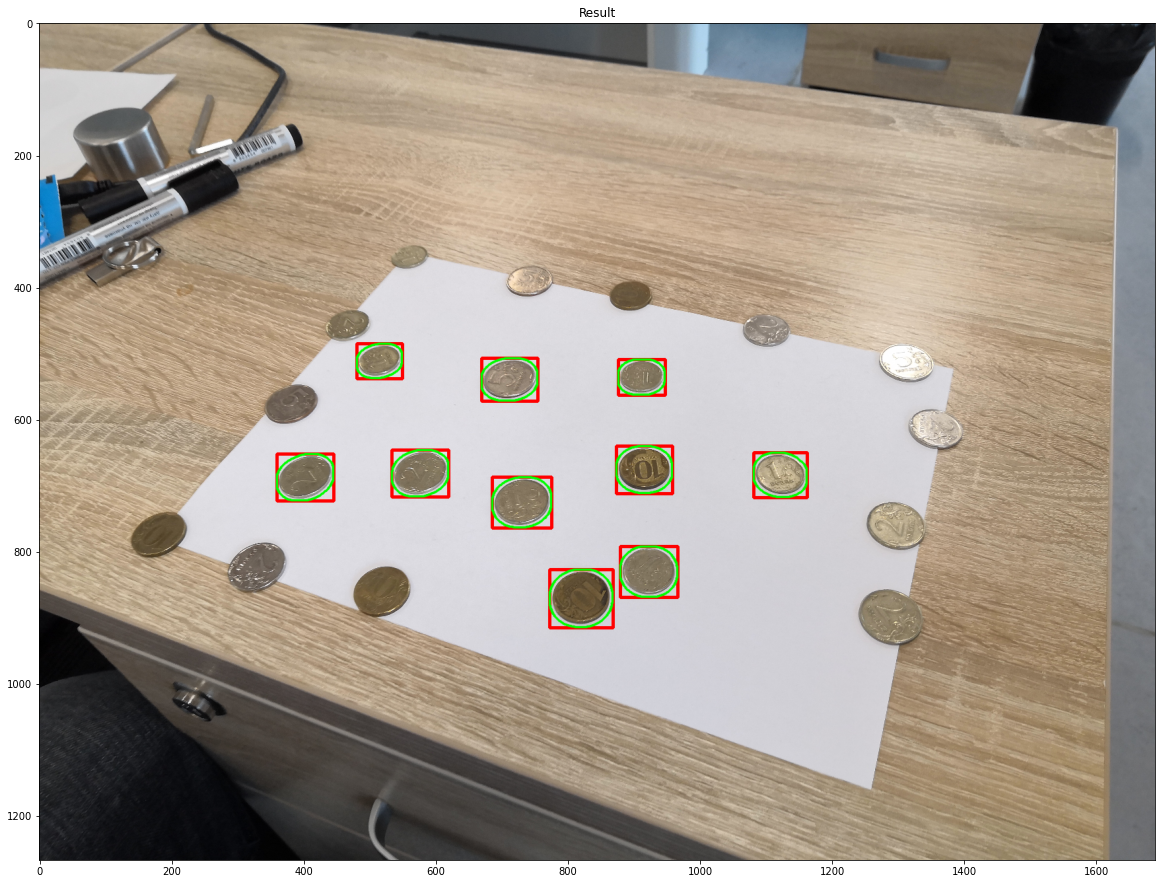

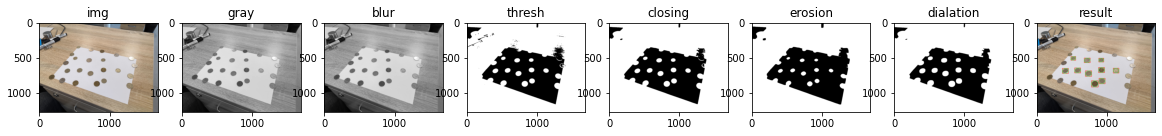

Total number of coins 10


In [11]:
def coins_calculator(img, display=False):
  """
  Function counts number of coins
  Input:
    image: grayscale or color image
  Output :
    total_val : total value of coins
  Note: First eliminate all coins touching the boundary of the paper
  """
  img_result = deepcopy(img)

  img_gray = deepcopy(img)

  if (not (len(img.shape) == 1 or img.shape[2] == 1)): # not grayscale -> colored
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
  img_list = [img, img_gray]
  img_list_labels = ["img", "gray"]
  # Blur
  img_blur = cv2.GaussianBlur(img_gray, (7,7), 0)
  img_list.append(img_blur)
  img_list_labels.append("blur")


  # Threshold the image
  ret, thresh = cv2.threshold(img_blur , 190, 255, cv2.THRESH_BINARY_INV)
  img_list.append(thresh)
  img_list_labels.append("thresh")


  # Morphological Transformations
  closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones((11,11),np.uint8))
  img_list.append(closing)
  img_list_labels.append("closing")

  erosion = cv2.erode(closing, np.ones((3,3),np.uint8),iterations = 5)
  img_list.append(erosion)
  img_list_labels.append("erosion")


  dialation = cv2.dilate(erosion, np.ones((3,3),np.uint8),iterations = 8)
  img_list.append(dialation)
  img_list_labels.append("dialation")

  # Find contours
  contours, hierarchy = cv2.findContours(dialation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  total_value = 0
  for cnt in contours[1:]: # Avoid the outer contours of the image
    x, y, w, h = cv2.boundingRect(cnt)
    if (cv2.pointPolygonTest(contours[2], (x,y), True) < 0):  # To check if the contour is inside or not the bounding box of the paper
        continue
    
    # Draw rectangle and text
    img_result = cv2.rectangle(img_result, (x,y), (x+w,y+h), (255,0,0), 3)
    cv2.drawContours(image=img_result, contours=[cnt], contourIdx=0, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)  # Draw the contour
    total_value += 1
    
  img_list.append(img_result)
  img_list_labels.append("result")

  if (display):
    showInRow([img_result], titles=["Result"])
    showInRow(img_list, titles=img_list_labels)
  return total_value

img = task3
total_value = coins_calculator(img, display=True)
print(f"Total number of coins {total_value}")